# Forecasting with Convolutional Neural Networks

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from matplotlib import style

import logging
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

style.use('ggplot')

In [0]:
def plot_the_series(time_, series_, format_='-', start=0, end=None, label=None):
  plt.plot(time_[start:end], series_[start:end], format_, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")

  if label:
    plt.legend(fontsize=10)

In [0]:
def trend(time_, slope_=0):
  return time_ * slope_

def seasonal_pattern(season_time):
  seasonal_pattern_arr = np.where(season_time < 0.4, 
                                  np.cos(season_time * 2 * np.pi), 
                                  1 / np.exp(3 * season_time))
  return seasonal_pattern_arr

def seasonality(time_, period, amplitude=1, phase=0):
  season_time = ((time_ + phase) % period) / period
  seasonality_added = amplitude * seasonal_pattern(season_time)
  return seasonality_added

def white_noise(time_, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed=seed)
  noised_arr = rnd.randn(len(time_)) * noise_level
  return noised_arr

In [0]:
amplitude = 40
baseline = 10
slope_ = 0.05

time_ = np.arange(4 * 365 + 1)
series_ = baseline + trend(time_=time_, slope_=slope_) + seasonality(time_=time_, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time_=time_, noise_level=noise_level, seed=42)

series_ += noise

In [8]:
print(time_)
print(series_)

[   0    1    2 ... 1458 1459 1460]
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


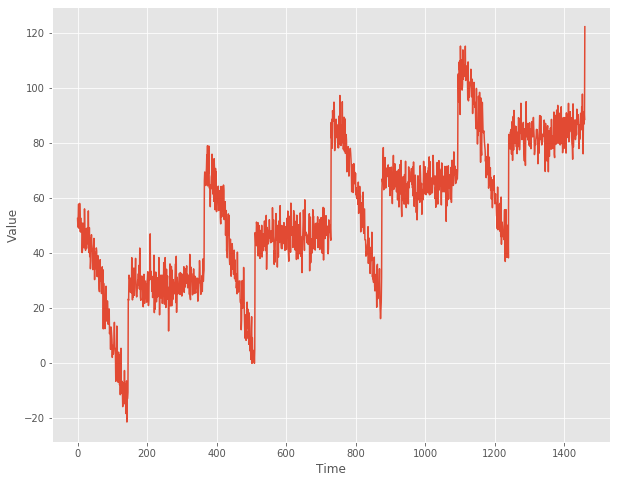

In [9]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_, series_=series_)
plt.show()

In [10]:
split_time = 1000

time_train = time_[:split_time]
x_train = series_[:split_time]

time_valid = time_[split_time:]
x_valid = series_[split_time:]

print("Number of observations in training period   : {}".format(len(x_train)))
print("Number of observations in validation period : {}".format(len(x_valid)))

Number of observations in training period   : 1000
Number of observations in validation period : 461


### Data Pipeline

In [0]:
def seq2seq_windowed_dataset(series_, window_size, batch_size=32, shuffle_buffer=1000):
  series_ = tf.expand_dims(input=series_, axis=-1)

  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[1:]))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)
  return dataset

In [0]:
def model_forecast(model, series_, window_size, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.batch(batch_size=batch_size).prefetch(1)

  forecasts = model.predict(dataset)
  return forecasts

### Processing with 1D Convolutional Layers

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = seq2seq_windowed_dataset(series_=x_train, 
                                        window_size=window_size, 
                                        batch_size=128)

In [0]:
model_1 = tf.keras.Sequential(layers=[
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5, 
                         strides=1, 
                         padding='causal', 
                         activation=tf.nn.relu, 
                         input_shape=[None, 1]), 
  tf.keras.layers.LSTM(units=32, return_sequences=True), 
  tf.keras.layers.LSTM(units=32, return_sequences=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model_1.fit(training_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 647ms/step - loss: 87.4947 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 1s 73ms/step - loss: 86.8595 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 1s 69ms/step - loss: 86.0590 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 1s 70ms/step - loss: 84.4440 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 1s 77ms/step - loss: 82.4501 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 1s 74ms/step - loss: 80.5387 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 1s 74ms/step - loss: 77.8250 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 1s 76ms/step - loss: 75.2095 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 1s 73ms/step - loss: 72.3287 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 1s 74ms/step - loss: 69.9495 - mae: 70.4036
Epoch 11/100
8/8 [==============================

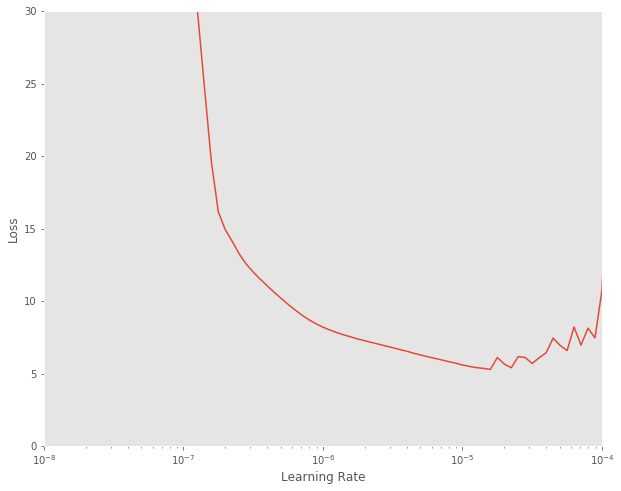

In [20]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = seq2seq_windowed_dataset(series_=x_train, 
                                        window_size=window_size, 
                                        batch_size=128)
validation_set = seq2seq_windowed_dataset(series_=x_valid, 
                                          window_size=window_size, 
                                          batch_size=128)

In [0]:
model_1 = tf.keras.Sequential(layers=[
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5, 
                         strides=1, 
                         padding='causal', 
                         activation=tf.nn.relu, 
                         input_shape=[None, 1]), 
  tf.keras.layers.LSTM(units=32, return_sequences=True), 
  tf.keras.layers.LSTM(units=32, return_sequences=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', save_best_only=True)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [26]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_1.fit(training_set, epochs=500, callbacks=[early_stopping, model_checkpoints], validation_data=validation_set)

Epoch 1/500
8/8 [==============================] - 6s 704ms/step - loss: 57.1561 - mae: 58.2706 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 90ms/step - loss: 24.1624 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 1s 88ms/step - loss: 16.7320 - mae: 17.2362 - val_loss: 37.3009 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 1s 95ms/step - loss: 14.4453 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 1s 90ms/step - loss: 11.1129 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 1s 92ms/step - loss: 9.3560 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 1s 94ms/step - loss: 7.9507 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 1s 95ms/

In [0]:
model_1 = tf.keras.models.load_model(filepath='./best_model.h5')

In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,865
Trainable params: 16,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv1d_lstm_forecasts = model_forecast(model=model_1, series_=series_[:, np.newaxis], window_size=window_size)

In [31]:
conv1d_lstm_forecasts_1D = conv1d_lstm_forecasts[split_time-window_size:-1, -1, 0]
print(conv1d_lstm_forecasts_1D)

array([ 63.33579 ,  65.99268 ,  67.28553 ,  66.42684 ,  65.579445,
        66.7695  ,  67.298164,  67.885124,  67.30176 ,  68.535774,
        67.501015,  68.00277 ,  67.84204 ,  69.517555,  67.546936,
        68.956924,  67.68828 ,  69.15069 ,  65.41376 ,  66.88042 ,
        66.733376,  66.46326 ,  65.86929 ,  65.13733 ,  66.58209 ,
        67.26593 ,  66.891846,  65.84037 ,  66.90804 ,  67.93211 ,
        66.92124 ,  65.93468 ,  64.442894,  65.59008 ,  64.4473  ,
        65.16034 ,  64.996666,  65.305046,  64.60183 ,  64.11835 ,
        64.37307 ,  65.39439 ,  64.81367 ,  65.5787  ,  66.23757 ,
        67.986626,  66.72401 ,  68.47075 ,  66.77999 ,  66.71898 ,
        67.055305,  67.85759 ,  65.55479 ,  67.448944,  69.254944,
        67.40569 ,  66.95232 ,  66.87218 ,  67.203896,  67.24288 ,
        66.48835 ,  66.355934,  65.19954 ,  66.01173 ,  64.41553 ,
        66.241196,  62.697952,  64.98739 ,  64.638054,  65.24736 ,
        65.56861 ,  65.15968 ,  67.6922  ,  67.271454,  66.917

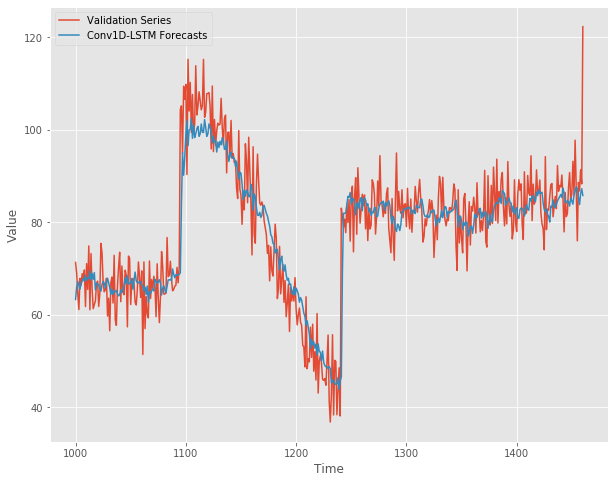

In [32]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid, label="Validation Series")
plot_the_series(time_=time_valid, series_=conv1d_lstm_forecasts_1D, label="Conv1D-LSTM Forecasts")
plt.show()

In [33]:
conv1d_lstm_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=conv1d_lstm_forecasts_1D).numpy()
print(conv1d_lstm_mae)

4.8744826


### Fully Convolutional Forecasting

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = seq2seq_windowed_dataset(series_=x_train, 
                                        window_size=window_size, 
                                        batch_size=128)

In [0]:
model_1 = tf.keras.Sequential()
model_1.add(layer=tf.keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in (1, 2, 4, 8, 16, 32):
  model_1.add(layer=tf.keras.layers.Conv1D(filters=32, 
                                           kernel_size=2, 
                                           strides=1, 
                                           padding='causal', 
                                           dilation_rate=dilation_rate, 
                                           activation=tf.nn.relu)
  )
model_1.add(layer=tf.keras.layers.Conv1D(filters=1, kernel_size=1))

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [39]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

In [40]:
history = model_1.fit(training_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 219ms/step - loss: 42.6105 - mae: 43.3904
Epoch 2/100
8/8 [==============================] - 0s 60ms/step - loss: 42.1168 - mae: 42.8548
Epoch 3/100
8/8 [==============================] - 0s 62ms/step - loss: 41.8800 - mae: 42.2535
Epoch 4/100
8/8 [==============================] - 0s 59ms/step - loss: 41.1861 - mae: 41.5636
Epoch 5/100
8/8 [==============================] - 0s 60ms/step - loss: 39.8608 - mae: 40.3345
Epoch 6/100
8/8 [==============================] - 0s 60ms/step - loss: 36.8113 - mae: 36.9698
Epoch 7/100
8/8 [==============================] - 0s 61ms/step - loss: 22.8171 - mae: 22.8870
Epoch 8/100
8/8 [==============================] - 1s 63ms/step - loss: 16.2293 - mae: 16.6272
Epoch 9/100
8/8 [==============================] - 0s 60ms/step - loss: 12.1291 - mae: 12.5404
Epoch 10/100
8/8 [==============================] - 0s 59ms/step - loss: 9.2286 - mae: 9.6776
Epoch 11/100
8/8 [==============================] 

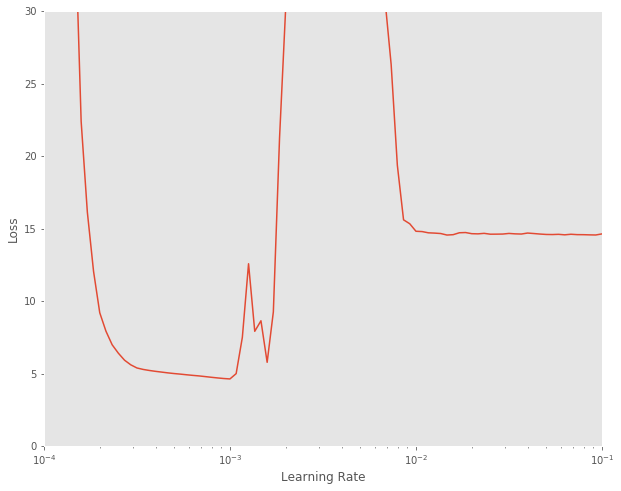

In [43]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = seq2seq_windowed_dataset(series_=x_train, 
                                        window_size=window_size, 
                                        batch_size=128)
validation_set = seq2seq_windowed_dataset(series_=x_valid, 
                                          window_size=window_size, 
                                          batch_size=128)

In [0]:
model_1 = tf.keras.Sequential()
model_1.add(layer=tf.keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in (1, 2, 4, 8, 16, 32):
  model_1.add(layer=tf.keras.layers.Conv1D(filters=32, 
                                           kernel_size=2, 
                                           strides=1, 
                                           padding='causal', 
                                           dilation_rate=dilation_rate, 
                                           activation=tf.nn.relu)
  )
model_1.add(layer=tf.keras.layers.Conv1D(filters=1, kernel_size=1))

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', save_best_only=True)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [49]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

In [50]:
model_1.fit(training_set, epochs=500, callbacks=[early_stopping, model_checkpoints], validation_data=validation_set)

Epoch 1/500
8/8 [==============================] - 3s 321ms/step - loss: 41.4889 - mae: 42.2711 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 75ms/step - loss: 40.3475 - mae: 40.8311 - val_loss: 70.2576 - val_mae: 71.3247
Epoch 3/500
8/8 [==============================] - 1s 75ms/step - loss: 35.2174 - mae: 34.0566 - val_loss: 28.5464 - val_mae: 28.9115
Epoch 4/500
8/8 [==============================] - 1s 72ms/step - loss: 17.9379 - mae: 18.8835 - val_loss: 31.6034 - val_mae: 32.2130
Epoch 5/500
8/8 [==============================] - 1s 77ms/step - loss: 15.9925 - mae: 15.2416 - val_loss: 14.0603 - val_mae: 14.5929
Epoch 6/500
8/8 [==============================] - 1s 76ms/step - loss: 9.7394 - mae: 10.1388 - val_loss: 10.4703 - val_mae: 10.9860
Epoch 7/500
8/8 [==============================] - 1s 78ms/step - loss: 7.9674 - mae: 8.3877 - val_loss: 8.9668 - val_mae: 9.4724
Epoch 8/500
8/8 [==============================] - 1s 78ms/s

In [0]:
model_1 = tf.keras.models.load_model('./best_model.h5')

In [52]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

In [0]:
full_conv1d_forecasts = model_forecast(model=model_1, series_=series_[..., np.newaxis], window_size=window_size)

In [55]:
print(full_conv1d_forecasts)
print(full_conv1d_forecasts.shape)

[[[51.848885]
  [50.10201 ]
  [51.751034]
  ...
  [44.117474]
  [45.347492]
  [44.554657]]

 [[48.723034]
  [51.218456]
  [55.747444]
  ...
  [44.958294]
  [45.1658  ]
  [43.74759 ]]

 [[52.678722]
  [55.443893]
  [52.553986]
  ...
  [44.543392]
  [44.39688 ]
  [44.926453]]

 ...

 [[81.95257 ]
  [83.91807 ]
  [87.36002 ]
  ...
  [86.544495]
  [87.31794 ]
  [87.25017 ]]

 [[84.897896]
  [86.642975]
  [88.63927 ]
  ...
  [87.01492 ]
  [88.04729 ]
  [86.45619 ]]

 [[87.464554]
  [87.8269  ]
  [84.68595 ]
  ...
  [87.82754 ]
  [87.19296 ]
  [98.356926]]]
(1432, 30, 1)


In [0]:
full_conv1d_forecasts_1D = full_conv1d_forecasts[split_time-window_size:-1, -1, 0]

In [57]:
print(full_conv1d_forecasts_1D)
print(full_conv1d_forecasts_1D.shape)

[ 62.921642  63.972996  66.382515  66.375595  65.60206   65.66049
  66.16187   66.46794   65.82927   65.71159   65.89169   66.41018
  66.50103   66.70051   66.447845  67.52902   66.60666   66.88733
  64.852646  64.88377   64.63512   64.34122   63.862976  63.889313
  64.459496  65.8438    66.902374  66.320885  66.68206   67.10599
  66.51121   64.829834  63.2706    63.49604   63.320404  63.442326
  62.246983  62.92067   63.263954  62.036736  63.26306   63.671997
  65.422195  65.07923   66.07124   66.3172    66.27186   66.271675
  65.12592   65.74654   66.07282   67.4916    65.49351   65.223434
  66.840904  65.84579   64.61281   64.67053   65.531105  65.91728
  65.53039   65.21619   63.525513  65.67584   62.870358  63.20259
  61.23224   62.085846  61.471016  62.53384   61.657127  62.424774
  64.605156  64.74814   64.569405  64.400696  65.5059    64.14622
  63.02394   63.930614  65.247665  65.66966   64.42411   65.196846
  66.666084  67.45523   67.34636   66.79521   68.71641   68.22485
  6

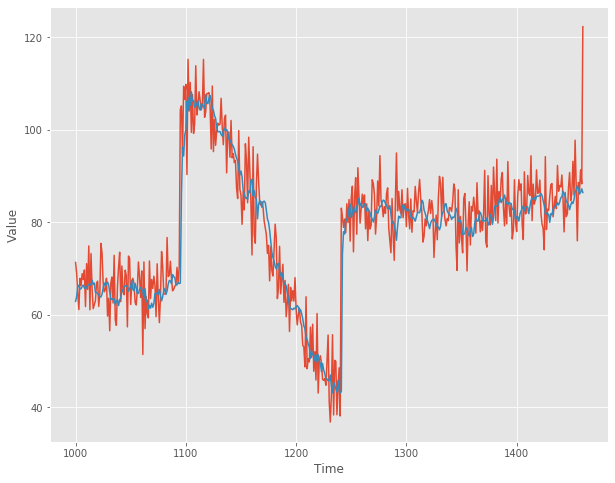

In [58]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid)
plot_the_series(time_=time_valid, series_=full_conv1d_forecasts_1D)
plt.show()

In [59]:
full_conv1d_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=full_conv1d_forecasts_1D).numpy()
print(full_conv1d_mae)

4.6409736
